# Evaluate the performance of CritterCounter models

We will use this to evaluate the performance of the models built for empty vs animal as well as a species classifier.

### Set up the environment

In [1]:
import os 
import pandas as pd
import re
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
import numpy as np
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [2]:
test_folder = '/data/holdout_set'

## Import the holdout data

### Create the data frame

In [3]:
test_file_paths = []

for root, sub, files in os.walk(test_folder):
    if len(files) > 0:
        test_file_paths += [os.path.join(root, file) for file in files]
        
df = pd.DataFrame({'path': test_file_paths})

df['category_name'] = df['path'].apply(lambda x: re.findall('/data/holdout_set/([a-z_]+)', x)[0])

#### Create the species specific dataset

In [4]:
species_subset = [
    'american_black_bear', 
    'bobcat', 
    'cougar', 
    'coyote', 
    'deer', 
    'domestic_cow', 
    'domestic_dog', 
    'elk', 
    'moose', 
    'vehicle', 
    'wild_turkey'
]

species_df = df[df['category_name'].isin(species_subset)]

In [5]:
print(len(species_df))
species_df['category_name'].value_counts()

2939


elk                    736
deer                   516
coyote                 451
american_black_bear    219
moose                  218
vehicle                209
wild_turkey            147
bobcat                 138
cougar                 120
domestic_cow            94
domestic_dog            91
Name: category_name, dtype: int64

## Species Model Evaluation

### Import the pretrained network

In [6]:
img_width, img_height = 224, 224
batch_size = 1
model_path = '/data/models/ResNet50/MobileNetV2_20190323_weights.h5'

In [7]:
# Define the model
ResNet50 = ResNet50(weights=None, include_top=False, input_shape=(img_width, img_height, 3))
print('Model loaded.')

# build a classifier model to put on top of the convolutional model
model = Sequential()
model.add(ResNet50)
model.add(Flatten(input_shape=model.output_shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(15, activation='softmax'))

# Load the pretrained weights
model.load_weights(model_path)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model loaded.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 15)                3855      
Total params: 49,281,935
Trainable params: 49,228,815
Non-trainable params: 53,120
______________________________________________________________

### Create the Generator

In [8]:
test_samples = len(species_df)

test_datagen = ImageDataGenerator(rescale=1/255.)

test_generator = test_datagen.flow_from_dataframe(
    species_df, 
    x_col='path', 
    y_col ='category_name', 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    shuffle=False,
    class_mode='categorical')

Found 2938 images belonging to 11 classes.


### Predict on the holdout set

In [9]:
predictions = model.predict_generator(
    test_generator, 
    steps=test_samples//batch_size,
    verbose=True
)

2939/2939 [==============================] - 237s 81ms/step


In [10]:
# Save results
np.save(file='/data/results/ResNet50_original_species_preds.npy', arr=predictions)

### Evaluation Results

#### Build Results DataFrame

In [11]:
id_map = {
    0: 'american_black_bear',
    1: 'bobcat',
    2: 'cougar',
    3: 'coyote',
    4: 'domestic_cow',
    5: 'domestic_dog',
    6: 'elk',
    7: 'gray_fox',
    8: 'moose',
    9: 'deer',
    10: 'elk',
    11: 'red_fox',
    12: 'vehicle',
    13: 'deer',
    14: 'wild_turkey',
    15: 'wolf'
}

In [12]:
preds = pd.DataFrame(predictions)
results_df = pd.concat([species_df.reset_index(drop=True), preds], axis=1)
results_df['top_class'] = pd.Series(predictions.argmax(axis=1))
results_df['top_prob'] = pd.Series(predictions.max(axis=1))
results_df['pred_category_name'] = results_df['top_class'].apply(lambda x: id_map[x])
results_df['top_1_acc'] = results_df['category_name'] == results_df['pred_category_name']

results_df['top_3_classes'] = pd.Series([list(i) for i in predictions.argsort(axis=1)[:,:-4:-1]])
results_df['top_3_classes'] = results_df['top_3_classes'].apply(lambda x: [id_map[i] for i in x])
results_df['top_3_acc'] = results_df.apply(lambda x: x['category_name'] in x['top_3_classes'], axis=1)

results_df['top_5_classes'] = pd.Series([list(i) for i in predictions.argsort(axis=1)[:,:-6:-1]])
results_df['top_5_classes'] = results_df['top_5_classes'].apply(lambda x: [id_map[i] for i in x])
results_df['top_5_acc'] = results_df.apply(lambda x: x['category_name'] in x['top_5_classes'], axis=1)

results_df.to_csv('/data/results/ResNet50_original_species_results.csv', index=False)

#### Evaluation Metrics

In [13]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, precision_recall_curve
import seaborn as sns; sns.set()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/font_manager.py:278: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [14]:
print('Top 1 Accuracy: {:.2%}'.format(results_df['top_1_acc'].mean()))
print('Top 3 Accuracy: {:.2%}'.format(results_df['top_3_acc'].mean()))
print('Top 5 Accuracy: {:.2%}'.format(results_df['top_5_acc'].mean()))
print('F1 Score: {:.2%}'.format(f1_score(results_df['category_name'], results_df['pred_category_name'], average='weighted')))
print('Precision Score: {:.2%}'.format(precision_score(results_df['category_name'], results_df['pred_category_name'], average='weighted')))
print('Recall Score: {:.2%}'.format(recall_score(results_df['category_name'], results_df['pred_category_name'], average='weighted')))


Top 1 Accuracy: 13.71%
Top 3 Accuracy: 31.61%
Top 5 Accuracy: 42.80%
F1 Score: 11.20%
Precision Score: 19.61%
Recall Score: 13.71%


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 

#### Categorical Breakdown

In [15]:
results_df.groupby('category_name')['top_1_acc'].mean()*100

category_name
american_black_bear    10.045662
bobcat                 10.144928
cougar                 25.833333
coyote                 62.305987
deer                    1.162791
domestic_cow           32.978723
domestic_dog            0.000000
elk                     2.445652
moose                   0.000000
vehicle                 0.000000
wild_turkey             0.000000
Name: top_1_acc, dtype: float64

In [16]:
results_df.pred_category_name.nunique()

11

In [17]:
results_df.groupby('category_name')['top_1_acc'].mean()

category_name
american_black_bear    0.100457
bobcat                 0.101449
cougar                 0.258333
coyote                 0.623060
deer                   0.011628
domestic_cow           0.329787
domestic_dog           0.000000
elk                    0.024457
moose                  0.000000
vehicle                0.000000
wild_turkey            0.000000
Name: top_1_acc, dtype: float64

In [22]:
conf_mat = confusion_matrix(results_df['category_name'], results_df['pred_category_name'])
pd.DataFrame(np.round(conf_mat/np.repeat(conf_mat.sum(axis=1), 13).reshape(13,13), 2))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.10,0.55,0.08,0.08,0.05,0.06,0.0,0.00,0.00,0.01,0.06,0.0,0.00
1,0.00,0.10,0.09,0.55,0.00,0.00,0.0,0.00,0.00,0.00,0.25,0.0,0.00
2,0.00,0.47,0.26,0.18,0.01,0.00,0.0,0.00,0.00,0.04,0.05,0.0,0.00
3,0.00,0.18,0.06,0.62,0.04,0.00,0.0,0.03,0.02,0.00,0.04,0.0,0.00
4,0.00,0.51,0.22,0.18,0.01,0.01,0.0,0.00,0.00,0.00,0.04,0.0,0.02
5,0.02,0.23,0.21,0.00,0.04,0.33,0.0,0.00,0.00,0.00,0.16,0.0,0.00
6,0.13,0.65,0.10,0.00,0.03,0.04,0.0,0.00,0.00,0.00,0.03,0.0,0.01
7,0.07,0.22,0.13,0.25,0.01,0.13,0.0,0.02,0.02,0.00,0.14,0.0,0.01
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.02,0.23,0.05,0.22,0.00,0.31,0.0,0.08,0.00,0.00,0.09,0.0,0.00


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


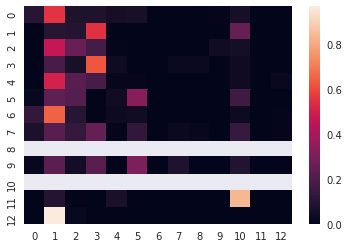

In [24]:
sns.heatmap(conf_mat/np.repeat(conf_mat.sum(axis=1), 13).reshape(13,13))

## Species Model Evaluation

### Import the pretrained network

In [8]:
img_width, img_height = 224, 224
batch_size = 1
model_path = '/data/ResNet50/ResNet50_20190404_species_weights.h5'

In [9]:
# Define the model
ResNet50 = ResNet50(weights=None, include_top=False, input_shape=(img_width, img_height, 3))
print('Model loaded.')

# build a classifier model to put on top of the convolutional model
model = Sequential()
model.add(ResNet50)
model.add(Flatten(input_shape=model.output_shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='softmax'))

# Load the pretrained weights
model.load_weights(model_path)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model loaded.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               25690368  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                4112      
Total params: 49,282,192
Trainable params: 49,229,072
Non-trainable params: 53,120
______________________________________________________________

### Create the Generator

In [10]:
test_samples = len(species_df)

test_datagen = ImageDataGenerator(rescale=1/255.)

test_generator = test_datagen.flow_from_dataframe(
    species_df, 
    x_col='path', 
    y_col ='category_name', 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    shuffle=False,
    class_mode='categorical')

Found 2938 images belonging to 11 classes.


### Predict on the holdout set

In [11]:
predictions = model.predict_generator(
    test_generator, 
    steps=test_samples//batch_size,
    verbose=True
)

2939/2939 [==============================] - 181s 62ms/step


In [12]:
# Save results
np.save(file='/data/results/ResNet50_species_preds.npy', arr=predictions)

### Evaluation Results

#### Build Results DataFrame

In [13]:
id_map = {
    0: 'american_black_bear',
    1: 'bobcat',
    2: 'cougar',
    3: 'coyote',
    4: 'domestic_cow',
    5: 'domestic_dog',
    6: 'elk',
    7: 'gray_fox',
    8: 'moose',
    9: 'deer',
    10: 'elk',
    11: 'red_fox',
    12: 'vehicle',
    13: 'deer',
    14: 'wild_turkey',
    15: 'wolf'
}

In [14]:
preds = pd.DataFrame(predictions)
results_df = pd.concat([species_df.reset_index(drop=True), preds], axis=1)
results_df['top_class'] = pd.Series(predictions.argmax(axis=1))
results_df['top_prob'] = pd.Series(predictions.max(axis=1))
results_df['pred_category_name'] = results_df['top_class'].apply(lambda x: id_map[x])
results_df['top_1_acc'] = results_df['category_name'] == results_df['pred_category_name']

results_df['top_3_classes'] = pd.Series([list(i) for i in predictions.argsort(axis=1)[:,:-4:-1]])
results_df['top_3_classes'] = results_df['top_3_classes'].apply(lambda x: [id_map[i] for i in x])
results_df['top_3_acc'] = results_df.apply(lambda x: x['category_name'] in x['top_3_classes'], axis=1)

results_df['top_5_classes'] = pd.Series([list(i) for i in predictions.argsort(axis=1)[:,:-6:-1]])
results_df['top_5_classes'] = results_df['top_5_classes'].apply(lambda x: [id_map[i] for i in x])
results_df['top_5_acc'] = results_df.apply(lambda x: x['category_name'] in x['top_5_classes'], axis=1)

results_df.to_csv('/data/results/ResNet50_species_results.csv', index=False)

#### Evaluation Metrics

In [15]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, precision_recall_curve
import seaborn as sns; sns.set()

In [16]:
print('Top 1 Accuracy: {:.2%}'.format(results_df['top_1_acc'].mean()))
print('Top 3 Accuracy: {:.2%}'.format(results_df['top_3_acc'].mean()))
print('Top 5 Accuracy: {:.2%}'.format(results_df['top_5_acc'].mean()))
print('F1 Score: {:.2%}'.format(f1_score(results_df['category_name'], results_df['pred_category_name'], average='weighted')))
print('Precision Score: {:.2%}'.format(precision_score(results_df['category_name'], results_df['pred_category_name'], average='weighted')))
print('Recall Score: {:.2%}'.format(recall_score(results_df['category_name'], results_df['pred_category_name'], average='weighted')))


Top 1 Accuracy: 43.93%
Top 3 Accuracy: 62.30%
Top 5 Accuracy: 69.41%
F1 Score: 44.20%
Precision Score: 64.49%
Recall Score: 43.93%


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


#### Categorical Breakdown

In [17]:
results_df.groupby('category_name')['top_1_acc'].mean()*100

category_name
american_black_bear    57.077626
bobcat                 44.202899
cougar                 50.000000
coyote                 70.066519
deer                    7.364341
domestic_cow           82.978723
domestic_dog            3.296703
elk                    45.108696
moose                  14.220183
vehicle                98.564593
wild_turkey            27.891156
Name: top_1_acc, dtype: float64

In [20]:
results_df.pred_category_name.nunique()

14

In [30]:
results_df.groupby('category_name')['top_1_acc'].mean()

category_name
american_black_bear    0.570776
bobcat                 0.442029
cougar                 0.500000
coyote                 0.700665
deer                   0.073643
domestic_cow           0.829787
domestic_dog           0.032967
elk                    0.451087
moose                  0.142202
vehicle                0.985646
wild_turkey            0.278912
Name: top_1_acc, dtype: float64

In [26]:
conf_mat = confusion_matrix(results_df['category_name'], results_df['pred_category_name'])
pd.DataFrame(np.round(conf_mat/np.repeat(conf_mat.sum(axis=1), 14).reshape(14,14), 2))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.57,0.21,0.02,0.06,0.02,0.08,0.00,0.01,0.0,0.01,0.0,0.00,0.01,0.00
1,0.00,0.44,0.30,0.24,0.01,0.00,0.00,0.00,0.0,0.00,0.0,0.01,0.00,0.00
2,0.00,0.35,0.50,0.12,0.00,0.00,0.00,0.01,0.0,0.00,0.0,0.00,0.00,0.02
3,0.00,0.19,0.09,0.70,0.02,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00
4,0.00,0.36,0.23,0.24,0.07,0.03,0.00,0.04,0.0,0.00,0.0,0.00,0.01,0.01
5,0.01,0.01,0.02,0.07,0.00,0.83,0.00,0.02,0.0,0.01,0.0,0.01,0.00,0.01
6,0.12,0.27,0.29,0.03,0.00,0.13,0.03,0.02,0.0,0.00,0.0,0.03,0.00,0.07
7,0.07,0.13,0.06,0.18,0.02,0.06,0.00,0.45,0.0,0.01,0.0,0.00,0.01,0.00
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.06,0.06,0.05,0.06,0.00,0.49,0.00,0.12,0.0,0.14,0.0,0.01,0.00,0.00


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


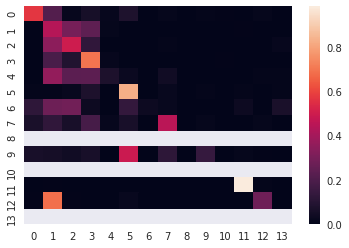

In [28]:
sns.heatmap(conf_mat/np.repeat(conf_mat.sum(axis=1), 14).reshape(14,14))

# Empty vs Non-Empty

#### Create the empty vs animal dataset

In [4]:
def empty_v_animal(label):
    if label == 'empty':
        return label
    else:
        return 'animal'

empty_df = df.copy()
empty_df['target'] = empty_df['category_name'].apply(empty_v_animal)


list_ = []
for key, grp in empty_df.groupby('target'):
    grp = grp.sample(frac=1).reset_index(drop=True)
    grp = grp[:200]
    list_.append(grp)
    
empty_df = pd.concat(list_)

In [5]:
print(len(empty_df))
empty_df['target'].value_counts()

382


animal    200
empty     182
Name: target, dtype: int64

## Species Model Evaluation

### Import the pretrained network

In [6]:
img_width, img_height = 224, 224
batch_size = 1
model_path = '/data/ResNet50/ResNet50_20190403_exclusiveEVA_weights.h5'

In [7]:
# Define the model
ResNet50 = ResNet50(weights=None, include_top=False, input_shape=(img_width, img_height, 3))
print('Model loaded.')

# build a classifier model to put on top of the convolutional model
model = Sequential()
model.add(ResNet50)
model.add(Flatten(input_shape=model.output_shape[1:]))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))

# Load the pretrained weights
model.load_weights(model_path)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


Model loaded.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               12845184  
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 36,433,154
Trainable params: 36,380,034
Non-trainable params: 53,120
______________________________________________________________

### Create the Generator

In [8]:
test_samples = len(empty_df)

test_datagen = ImageDataGenerator(rescale=1/255.)

test_generator = test_datagen.flow_from_dataframe(
    empty_df, 
    x_col='path', 
    y_col ='target', 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    shuffle=False,
    class_mode='categorical')

Found 381 images belonging to 2 classes.


### Predict on the holdout set

In [9]:
predictions = model.predict_generator(
    test_generator, 
    steps=test_samples//batch_size,
    verbose=True
)

382/382 [==============================] - 31s 82ms/step


In [10]:
# Save results
np.save(file='/data/results/ResNet50_empty_preds.npy', arr=predictions)

### Evaluation Results

#### Build Results DataFrame

In [11]:
id_map = {
    0: 'animal',
    1: 'empty'
}

In [12]:
preds = pd.DataFrame(predictions)
results_df = pd.concat([empty_df.reset_index(drop=True), preds], axis=1)
results_df['top_class'] = pd.Series(predictions.argmax(axis=1))
results_df['top_prob'] = pd.Series(predictions.max(axis=1))
results_df['pred_category_name'] = results_df['top_class'].apply(lambda x: id_map[x])
results_df['acc'] = 1.0*(results_df['target'] == results_df['pred_category_name'])
results_df.to_csv('/data/results/ResNet50_empty_results.csv', index=False)

In [13]:
results_df.groupby(['target'])['acc'].mean()

target
animal    0.535000
empty     0.950549
Name: acc, dtype: float64

#### Evaluation Metrics

In [14]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, precision_recall_curve
import seaborn as sns; sns.set()

In [15]:
print('Accuracy: {:.2%}'.format(results_df['acc'].mean()))
print('F1 Score: {:.2%}'.format(f1_score(results_df['target'], results_df['pred_category_name'], average='weighted')))
print('Precision Score: {:.2%}'.format(precision_score(results_df['target'], results_df['pred_category_name'], average='weighted')))
print('Recall Score: {:.2%}'.format(recall_score(results_df['target'], results_df['pred_category_name'], average='weighted')))


Accuracy: 73.30%
F1 Score: 72.25%
Precision Score: 79.28%
Recall Score: 73.30%


#### Categorical Breakdown

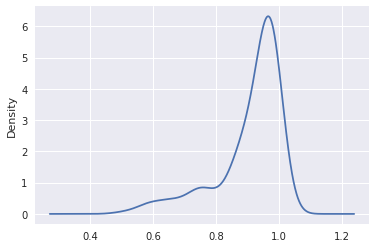

In [16]:
results_df[(results_df['target']=='empty') & (results_df['top_class']==1)]['top_prob'].plot.density()

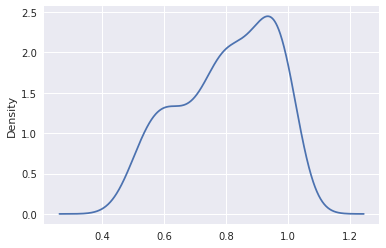

In [17]:
results_df[(results_df['target']=='animal') & (results_df['top_class']==0)]['top_prob'].plot.density()

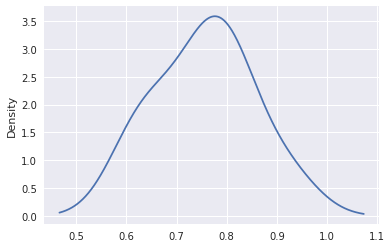

In [18]:
results_df[(results_df['target']=='empty') & (results_df['top_class']==0)]['top_prob'].plot.density()

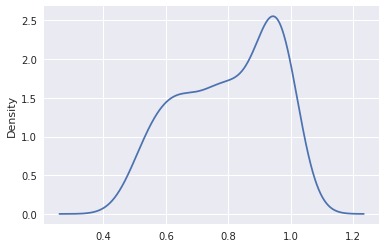

In [19]:
results_df[(results_df['target']=='animal') & (results_df['top_class']==1)]['top_prob'].plot.density()

In [20]:
results_df.groupby('category_name')['acc'].mean()

category_name
american_black_bear    0.916667
bobcat                 0.076923
cougar                 0.600000
coyote                 0.137931
deer                   0.692308
domestic_cow           1.000000
domestic_dog           1.000000
elk                    0.681818
empty                  0.950549
human                  0.333333
moose                  0.733333
non_target_species     0.333333
vehicle                0.615385
wild_turkey            0.666667
Name: acc, dtype: float64

In [21]:
conf_mat = confusion_matrix(results_df['target'], results_df['pred_category_name'])
pd.DataFrame(np.round(conf_mat/np.repeat(conf_mat.sum(axis=1), 2).reshape(2,2), 2))

,0,1
0,0.54,0.46
1,0.05,0.95


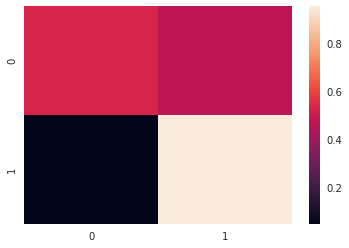

In [22]:
sns.heatmap(conf_mat/np.repeat(conf_mat.sum(axis=1), 2).reshape(2,2))